In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import feature_manager as fma
import rl.env_simple_crypto_trade as env
import importlib
from stable_baselines3 import A2C, PPO
import matplotlib.pyplot as plt

In [ ]:
fm = fma.FeatureManager(target_col="trade_signal")
fm.import_trading_data(symbol="BTCUSDT",trade_timeframe="4h")
fm.import_macro_data(symbol="BTCUSDT",macro_timeframe="1d")
fm.import_super_data(symbol="BTCUSDT",super_timeframe="1w")

FEATURES = [
    "sma_3_10",
    "sma_7_30",
    "sma_14_50",
    "rsi14",
    "rsi30",
    "obv",
    "mfi14",
]
fm.build_features(lags = 1,macro_lags=1,super_lags=1,features=FEATURES,macro_features=FEATURES,super_features=FEATURES)


In [ ]:
fm.df

In [ ]:
train = fm.df.iloc[-4000:-2000]
trade = fm.df.iloc[-2000:]
trade_2 = fm.df.iloc[-6000:-4000]

In [ ]:
state_space = 3 + len(fm.cols)
env_kwargs = {
    "buy_trading_fee" : 0.0002,
    "sell_trading_fee" : 0.0002,
    "take_profit_rate" : 0.02,
    "stop_loss_rate" : -0.01,
    "money_sleep_cost" : 0.00001,
    "state_space": state_space,
    "indicators": fm.cols,
    "reward_scaling": 1
}

In [ ]:
importlib.reload(env)
train_env = env.CryptoTradingEnv(df = train, **env_kwargs)
print(type(train_env))

In [ ]:
model = PPO('MlpPolicy',train_env,verbose=1)

In [20]:
train_env.reset()
model.learn(total_timesteps=10_000,reset_num_timesteps=False)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.04e+03 |
|    ep_rew_mean     | -2.88    |
| time/              |          |
|    fps             | 396      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 12288    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.03e+03    |
|    ep_rew_mean          | -2.56       |
| time/                   |             |
|    fps                  | 294         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.004137093 |
|    clip_fraction        | 0.0259      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.014       |
|    learning_rate        | 0.

<AxesSubplot: xlabel='Open Time'>

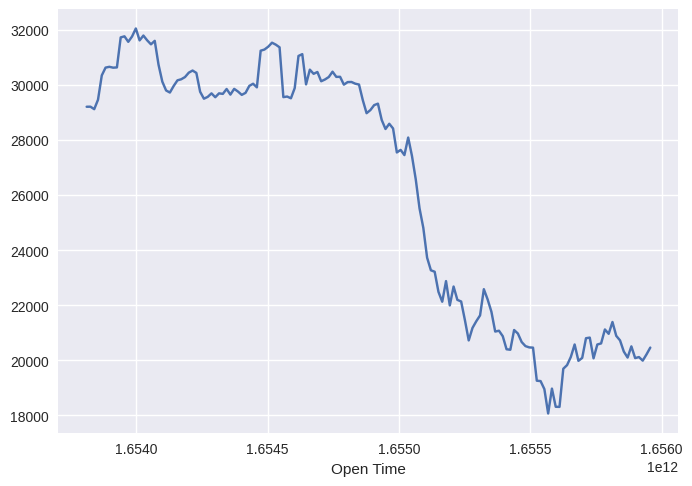

In [29]:
trade_env.df.iloc[700:850]["Close"].plot()

1: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
2: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
3: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
4: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
5: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
6: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
7: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
8: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
9: Previous: NETRAUL | Action: NETRAUL | Reward: -1e-05 | Profit : 0.0 False
10: Previous: NETRAUL | Action: SHORT | Reward: -0.0002 | Profit : -0.0002 False
11: Previous: SHORT | Action: SHORT | Reward: 0.0 | Profit : 0.00646 False
12: Previous: SHORT | Action: NETRAUL | Reward: -0.0002 | Profit : 0.00288 False
13: Previous: NETRAUL | Action: SHORT | Reward: -0.0002 | Profit : -0.

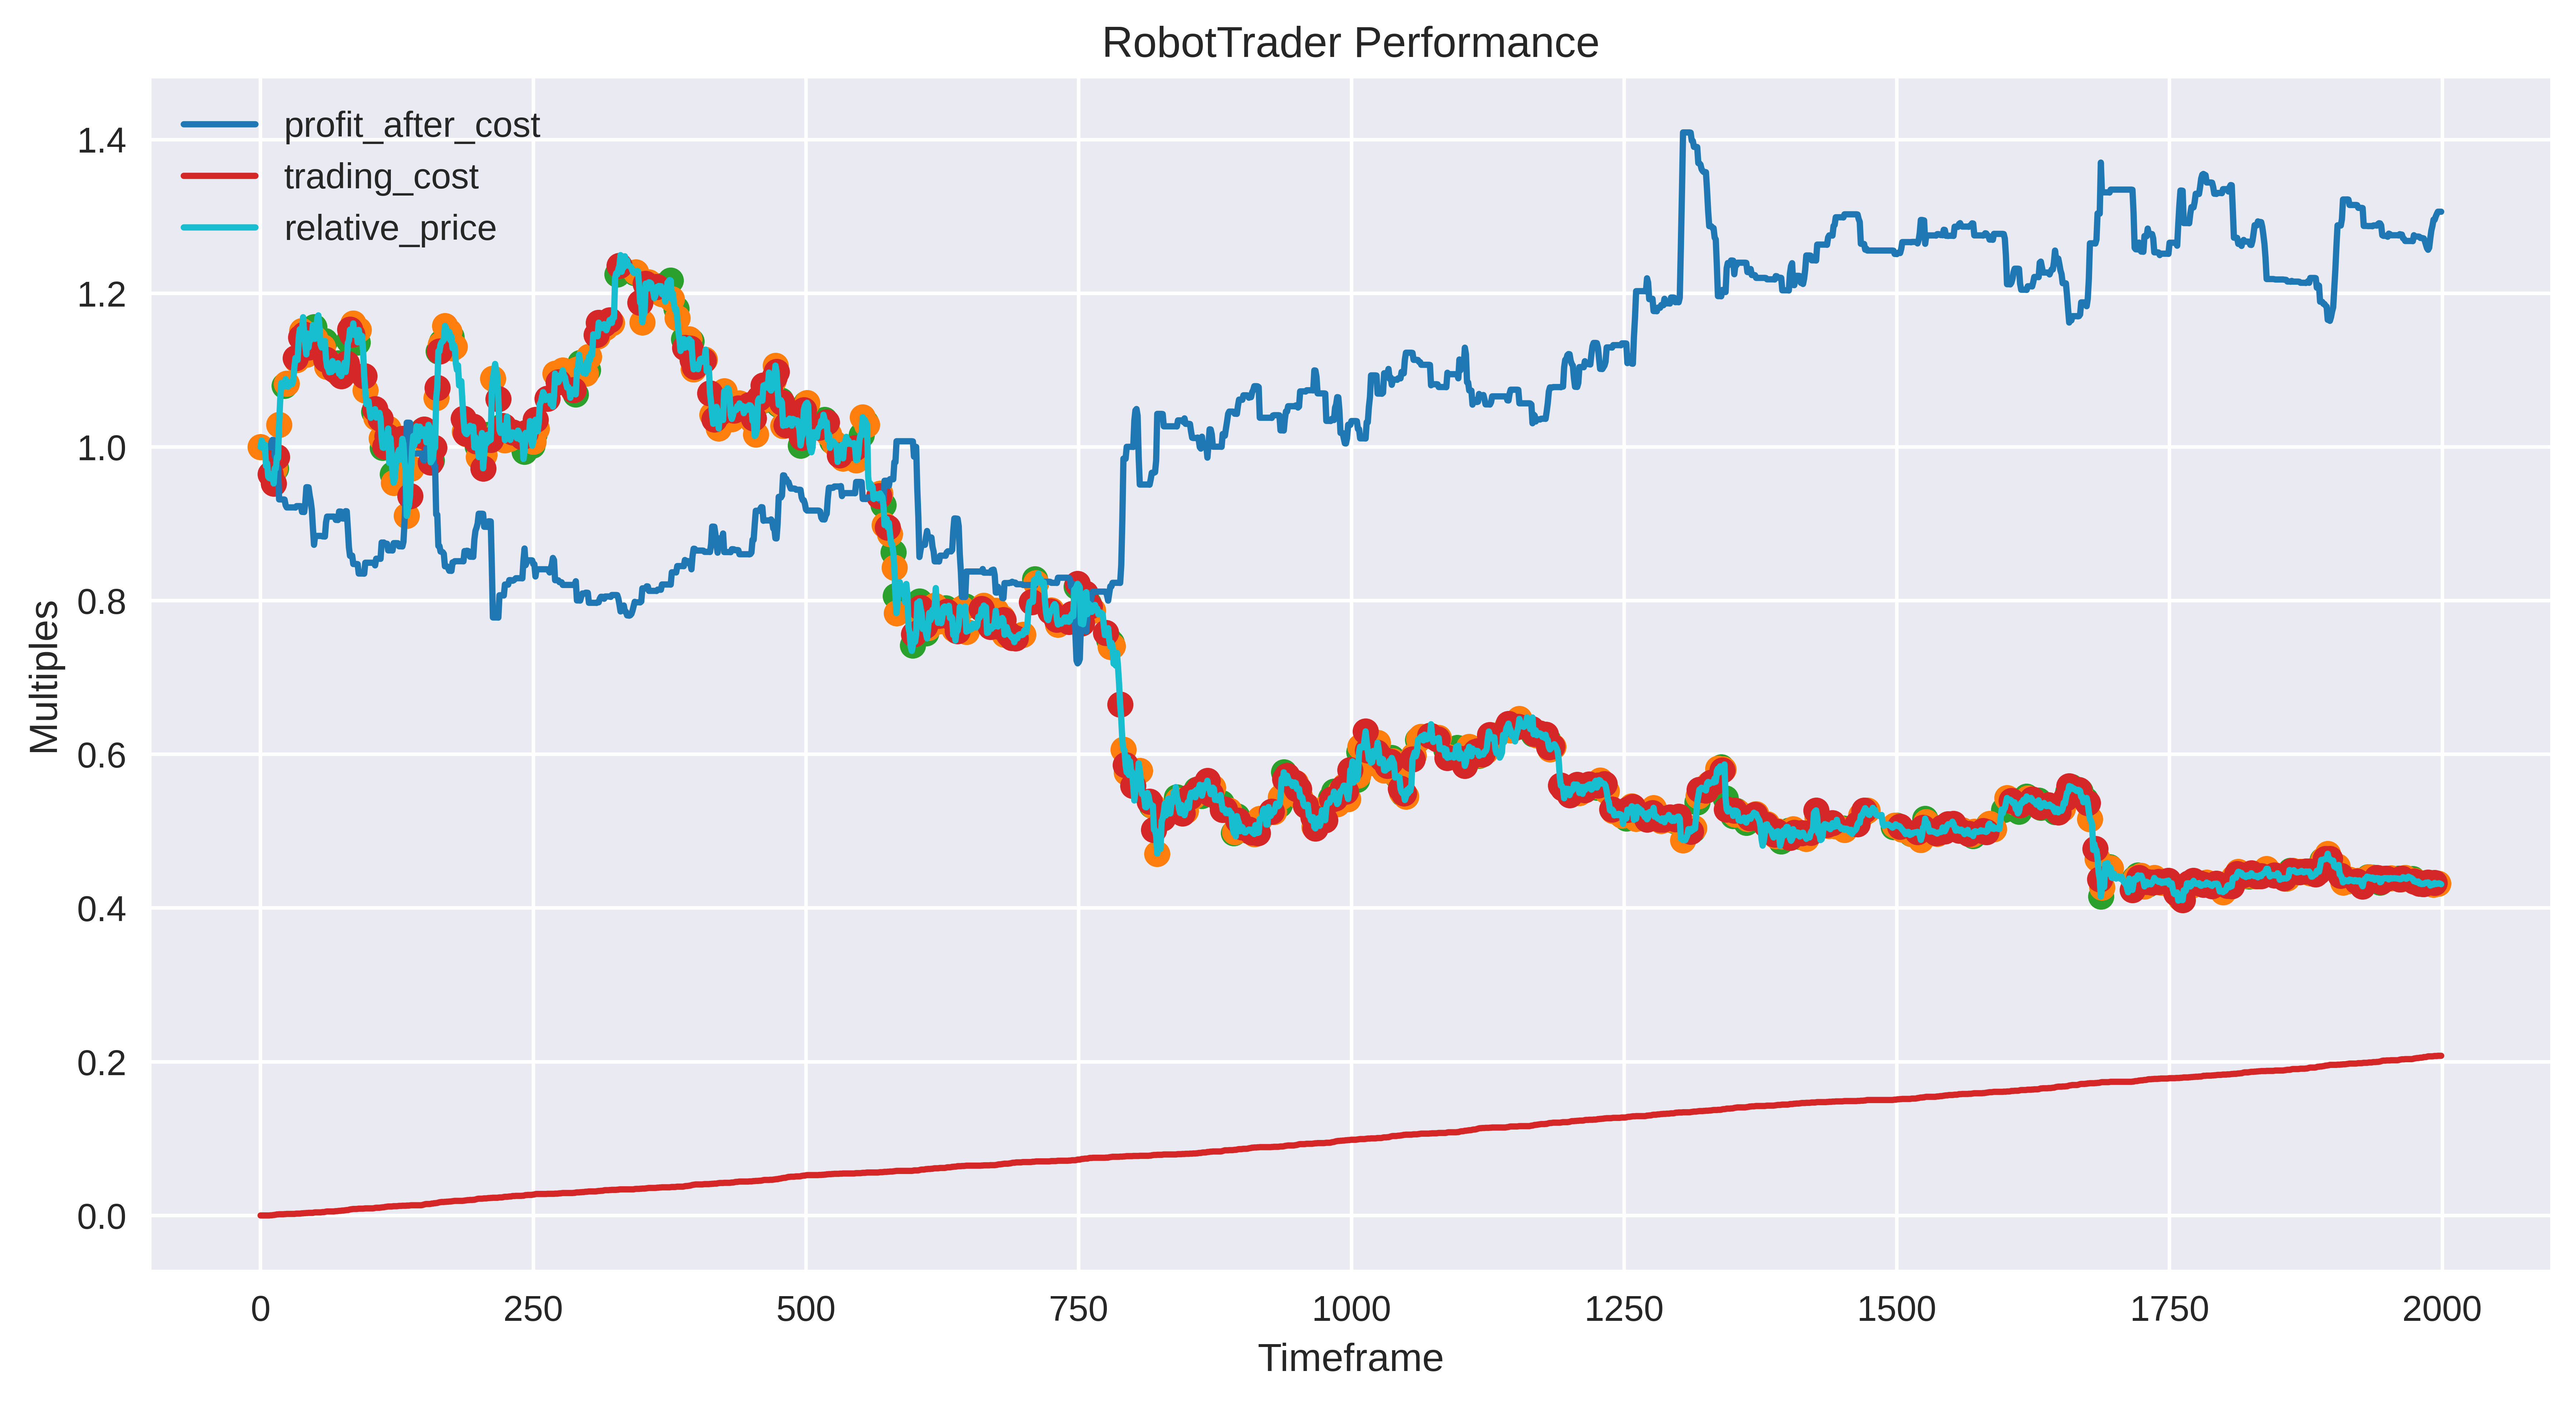

In [36]:
trade_env = env.CryptoTradingEnv(df = trade, **env_kwargs)
done = False
obs = trade_env.reset()
while not done:
    action, states= model.predict(obs)
    obs, reward, done, info = trade_env.step(action)
    trade_env.render()
result = trade_env.make_result_data()
trade_env.plot_multiple(result)